In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import sklearn
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from datetime import timedelta
import time

In [0]:
# df_fraud = pd.read_csv('Fraud_Data.csv')
# df_ipad_country = pd.read_csv('IpAddress_to_Country.csv')

# Relier les adresses ip et pays 

In [0]:
# # Chargement des datasets
# dataset = pd.read_csv("Fraud_Data.csv")
# countries = pd.read_csv("IpAddress_to_Country.csv")
# # Fonction pour amener le nom des pays du dataset secondaire vers le dataset principal
# def transform_ip(arg) :
#     try :
#         return countries.country[(countries.lower_bound_ip_address < arg) & (countries.upper_bound_ip_address > arg)].iloc[0]
#     except IndexError :
#         return "Pays inconnu"  
# dataset["Pays"] = dataset.ip_address.apply(transform_ip)

In [0]:
# new file save
df = pd.read_csv('Fraud_with_countries.csv')

In [0]:
#nb of frauds
print("number of clean",df['class'].value_counts()[0])
print("number of fraud", df['class'].value_counts()[1])
print("percentage of fraud {}%".format(round(df['class'].value_counts()[1]/len(df),4)))
# percentage fraude by sex
print("percentage of fraud female {}%".format(df.groupby('sex').mean()['class'][0]))
print("percentage of fraud female {}%".format(df.groupby('sex').mean()['class'][1]))

number of clean 136961
number of fraud 14151
percentage of fraud 0.0936%
percentage of fraud female 0.09100749773157803%
percentage of fraud female 0.09552286138198951%


In [0]:
## percetange fraude by country
a =pd.DataFrame(df.groupby('country').mean()['class'])
a = a[a['class']>0].sort_values(by = 'class', ascending = False)
a['nb_of_connexion'] = df.country.value_counts()
a[:10]

,class,nb_of_connexion
country,,
Turkmenistan,1.000000,1
Namibia,0.434783,23
Sri Lanka,0.419355,31
Luxembourg,0.388889,72
Virgin Islands (U.S.),0.333333,3
Ecuador,0.264151,106
Tunisia,0.262712,118
Peru,0.260504,119
Bolivia,0.245283,53


In [0]:
b=a.sort_values(by = 'nb_of_connexion', ascending = False)
b[:10]

,class,nb_of_connexion
country,,
United States,0.095626,58049
China,0.086642,12038
Japan,0.097865,7306
United Kingdom,0.106236,4490
Korea Republic of,0.091302,4162
Germany,0.071860,3646
France,0.094907,3161
Canada,0.116975,2975
Brazil,0.091185,2961


# Modification des features

# Dates

In [0]:
#convert to datetime
df['signup_time']=pd.to_datetime(df['signup_time'])
df['purchase_time']=pd.to_datetime(df['purchase_time'])

In [0]:
# add new columns

df['signup_date'] = df['signup_time'].apply(lambda x : x.strftime('%d/%m/%Y'))
df['signup_hour'] = df['signup_time'].apply(lambda x : x.strftime('%H:%M:%S'))

df['purchase_date'] = df['purchase_time'].apply(lambda x : x.strftime('%d/%m/%Y'))
df['purchase_hour'] = df['purchase_time'].apply(lambda x : x.strftime('%H:%M:%S'))

df["day_of_purchased"] = df["purchase_time"].map(lambda d: d.day)
df["week_of_purchased"] = [int((jour-1)*4/31)+1 for jour in df["day_of_purchased"]]

In [0]:
df['signup_MONTH'] = df['signup_time'].apply(lambda x : x.strftime('%B'))
df['signup_DAY'] = df['signup_time'].apply(lambda x : x.strftime('%A'))

df['purchase_MONTH'] = df['purchase_time'].apply(lambda x : x.strftime('%B'))
df['purchase_DAY'] = df['purchase_time'].apply(lambda x : x.strftime('%A'))


In [0]:
#add columns 
df['time_to_purchase'] = (df['purchase_time'] - df['signup_time'])
df['day_to_purchase'] = df['time_to_purchase'].apply(lambda x : x.days)

In [0]:
#function to extract h/m/s from timedelta
def extract_hours(x):
    days = x.days
    hours, remainder = divmod(x.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return hours
def extract_minutes(x):
    days = x.days
    hours, remainder = divmod(x.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return minutes
def extract_seconds(x):
    days = x.days
    #hours, remainder = divmod(a.seconds, 3600)
    hours, remainder = divmod(x.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return seconds

df['hours_to_purchase'] = df['time_to_purchase'].apply(lambda x : extract_hours(x))
df['minutes_to_purchase'] = df['time_to_purchase'].apply(lambda x : extract_minutes(x))
df['second_to_purchase'] = df['time_to_purchase'].apply(lambda x : extract_seconds(x))

In [0]:
#add column to speed 
df['to_speed_for_purchase'] = df.apply(lambda row: 1 if row['minutes_to_purchase']<1 & row['second_to_purchase']<2
                                    else 0, axis=1)

In [0]:
## add column if purchased during morning
df['AM'] = df['purchase_time'].apply(lambda x : 1 if x.strftime('%p')=='AM' else 0)
## a modifier -> avec liste d'horaires 

In [0]:
# df['to_speed_for_purchase'] = df.apply(lambda row: 1 if row['minutes_to_purchase']<1 & row['second_to_purchase']<2
#                                     else 0, axis=1)

In [0]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,signup_DAY,purchase_MONTH,purchase_DAY,time_to_purchase,day_to_purchase,hours_to_purchase,minutes_to_purchase,second_to_purchase,to_speed_for_purchase,AM
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,Tuesday,April,Saturday,52 days 03:51:22,52,3,51,22,0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,Sunday,June,Monday,0 days 04:59:04,0,4,59,4,0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,Thursday,January,Thursday,0 days 00:00:01,0,0,0,1,1,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,Tuesday,May,Monday,5 days 16:41:25,5,16,41,25,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,Tuesday,September,Wednesday,50 days 11:31:01,50,11,31,1,0,0


## DEVICE

In [0]:
device_nb = pd.DataFrame({'count' :df.device_id.value_counts()})
device_nb['device_id'] = device_nb.index
df = df.merge(device_nb, on='device_id', how='left')

In [0]:
ip_nb =  pd.DataFrame({'count' :df.ip_address.value_counts()})
ip_nb['ip_address'] = ip_nb.index

In [0]:
df = df.merge(ip_nb, on='ip_address', how='left')

In [0]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,purchase_DAY,time_to_purchase,day_to_purchase,hours_to_purchase,minutes_to_purchase,second_to_purchase,to_speed_for_purchase,AM,count_x,count_y
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,Saturday,52 days 03:51:22,52,3,51,22,0,1,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,Monday,0 days 04:59:04,0,4,59,4,0,1,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,Thursday,0 days 00:00:01,0,0,0,1,1,0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,Monday,5 days 16:41:25,5,16,41,25,0,0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,Wednesday,50 days 11:31:01,50,11,31,1,0,0,1,1


In [0]:
df.rename(columns={'count_x':'Device_apparition', 
                       'count_y' : 'Ip_apparition'}, inplace=True)

In [0]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,purchase_DAY,time_to_purchase,day_to_purchase,hours_to_purchase,minutes_to_purchase,second_to_purchase,to_speed_for_purchase,AM,Device_apparition,Ip_apparition
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,Saturday,52 days 03:51:22,52,3,51,22,0,1,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,Monday,0 days 04:59:04,0,4,59,4,0,1,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,Thursday,0 days 00:00:01,0,0,0,1,1,0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,Monday,5 days 16:41:25,5,16,41,25,0,0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,Wednesday,50 days 11:31:01,50,11,31,1,0,0,1,1


In [0]:
clean = df[df['class']==0]
fraud = df[df['class']==1]

# Visualisation

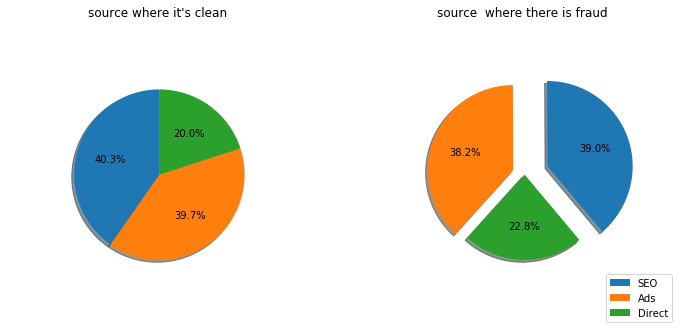

In [0]:
size_clean = clean['source'].value_counts(normalize=True)
size_fraud = fraud['source'].value_counts(normalize=True)

labels_sources = list(df.source.unique())

f, [ax1,ax2] = plt.subplots(1,2,figsize=(12,12))
explode = (0.2,0.1,0)

ax1.pie(size_clean,autopct='%1.1f%%', shadow=True, startangle=90, radius = 0.7)
#plt.legend(labels_goal, loc = 3)
ax1.set(title ="source where it's clean ")
plt.legend(labels_sources, loc = 3)
ax2.pie(size_fraud,autopct='%1.1f%%', explode = explode, shadow=True, startangle=-50, radius = 0.7);
ax2.set(title = "source  where there is fraud ")
plt.legend(labels_sources, loc = 4)
plt.show()

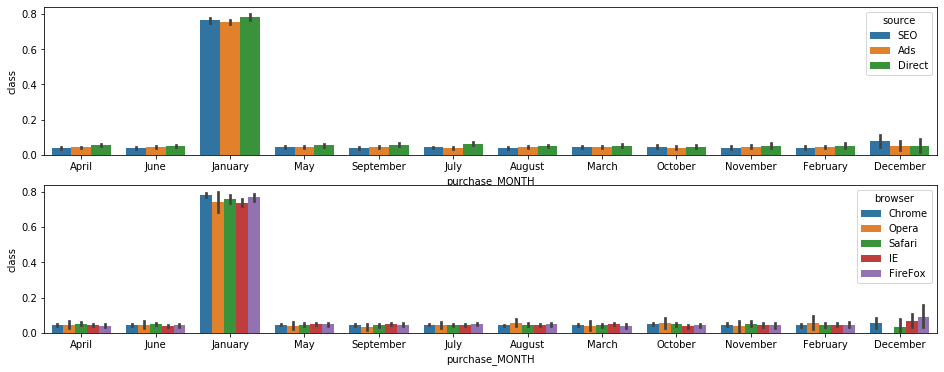

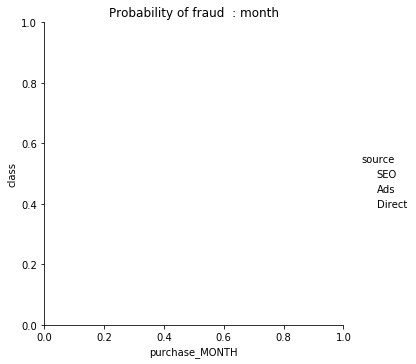

In [0]:
fig, axis1 = plt.subplots(2,1,figsize=(16,6))
sns.catplot(x="purchase_MONTH", y="class", hue = 'source',kind = 'bar',  data=df, ax=axis1[0]);
plt.title("Probability of fraud  : month");
sns.catplot(x="purchase_MONTH", y="class", hue = 'browser',kind = 'bar',  data=df, ax=axis1[1]);
#plt.xticks(rotation=45, size = 8, weight = 'bold');
plt.close()

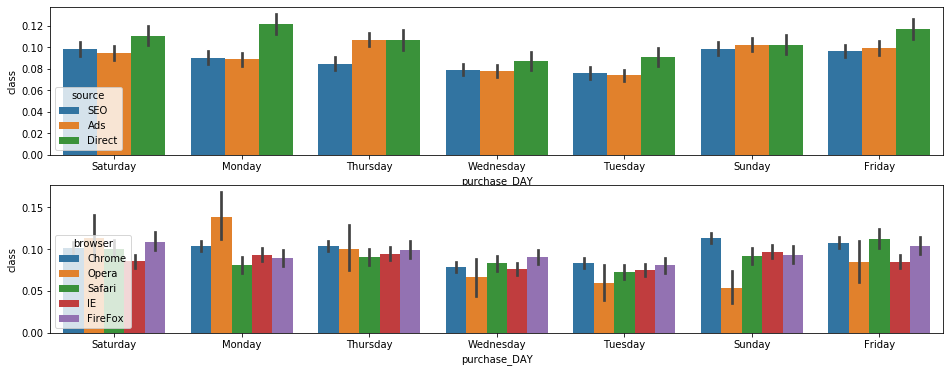

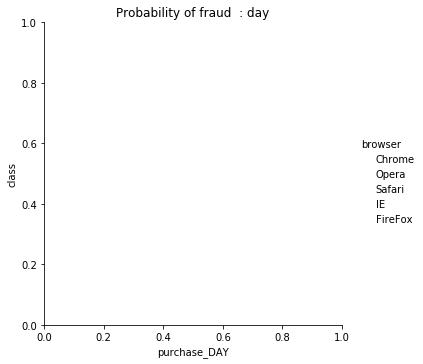

In [0]:
fig, axis1 = plt.subplots(2,1,figsize=(16,6))
sns.catplot(x="purchase_DAY", y="class", hue="source", kind="bar", data=df, ax=axis1[0]);
plt.title("Probability of fraud  : day");
sns.catplot(x="purchase_DAY", y="class", hue="browser", kind="bar", data=df, ax=axis1[1]);
plt.title("Probability of fraud  : day");
plt.close(2)

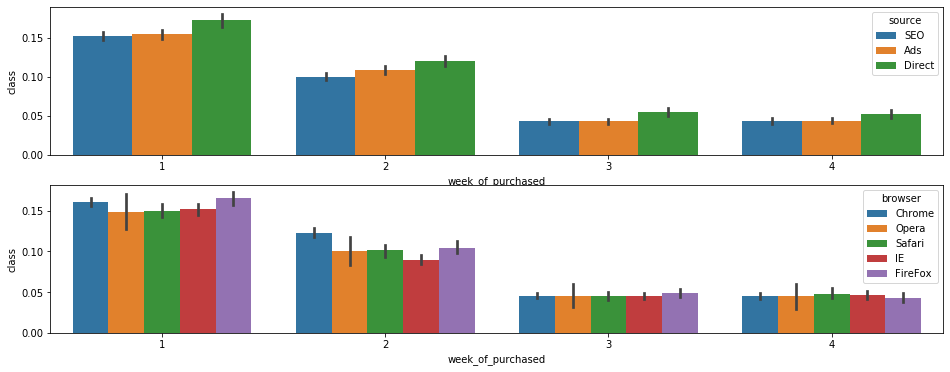

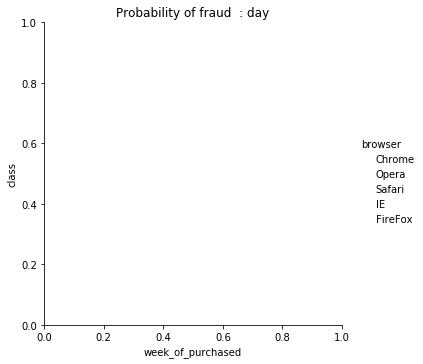

In [0]:
fig, axis1 = plt.subplots(2,1,figsize=(16,6))
sns.catplot(x="week_of_purchased", y="class", hue="source", kind="bar", data=df, ax=axis1[0]);
plt.title("Probability of fraud  : day");
sns.catplot(x="week_of_purchased", y="class", hue="browser", kind="bar", data=df, ax=axis1[1]);
plt.title("Probability of fraud  : day");
plt.close(2)

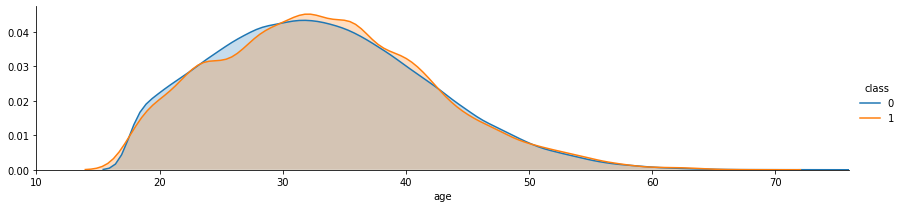

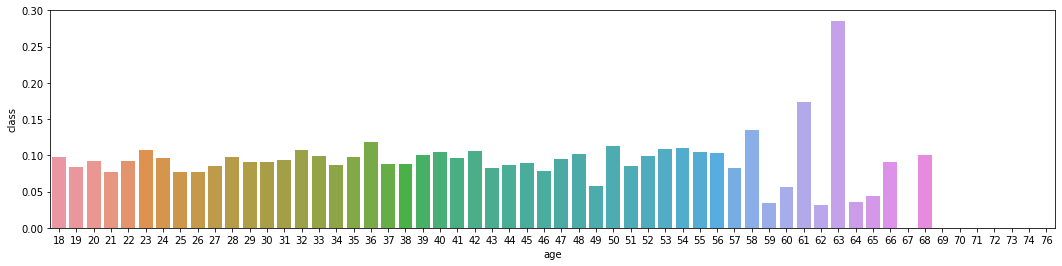

In [0]:
facet = sns.FacetGrid(df, hue="class", aspect=4)
facet.map(sns.kdeplot,'age', shade = True)
facet.set(xlim=(10, df['age'].max()))
facet.add_legend()
# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = df[["age", "class"]].groupby(['age'],as_index=False).mean()
sns.barplot(x='age', y='class', data=average_age)

In [0]:
# labelencoder=LabelEncoder()
# colonnes = ['source', 'browser', 'sex']
# classes_ = []
# for col in colonnes:
#     df_users[col] = labelencoder.fit_transform(df_users[col])
#     classes_.append(list(labelencoder.classes_))
#     print(classes_)

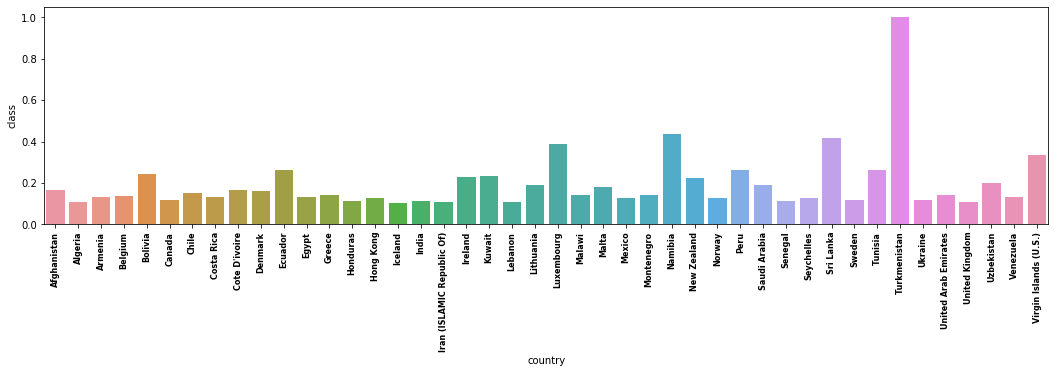

In [0]:
# percentage of fraud group by pays
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_fraud = df[["country", "class"]].groupby(['country'],as_index=False).mean()
sns.barplot(x='country', y='class', data=average_fraud[average_fraud['class']>0.1]);
plt.xticks(rotation=90, size = 8, weight = 'bold');

# Machine Learning

## regression logistique

In [0]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,signup_DAY,purchase_MONTH,purchase_DAY,time_to_purchase,day_to_purchase,hours_to_purchase,minutes_to_purchase,second_to_purchase,to_speed_for_purchase,AM
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,Tuesday,April,Saturday,52 days 03:51:22,52,3,51,22,0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,Sunday,June,Monday,0 days 04:59:04,0,4,59,4,0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,Thursday,January,Thursday,0 days 00:00:01,0,0,0,1,1,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,Tuesday,May,Monday,5 days 16:41:25,5,16,41,25,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,Tuesday,September,Wednesday,50 days 11:31:01,50,11,31,1,0,0


In [0]:
y=df['class']
X = df.drop(['class', 'user_id', 'device_id', 'time_to_purchase', 
            'signup_time', 'purchase_time', 'ip_address', 'signup_date', 'signup_hour', 
             'purchase_date','purchase_hour', 'time_to_purchase'
            ], axis = 1)

In [0]:
X = X.drop(['signup_MONTH', 'signup_DAY'], axis = 1)

In [0]:
X = pd.get_dummies(X, drop_first = True)
#enregristre le nom des colonnes 
X_columns = X.columns

In [0]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=.3, random_state = 42, stratify = y)

In [0]:
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

In [0]:
# Application du modèle 
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print("Logistic classifier".center(50, "-"))
print("Logistic score on train :",classifier.score(X_train, y_train))  ### donne l'accuracy
print("Logistic score on test", classifier.score(X_test, y_test))

---------------Logistic classifier----------------
Logistic score on train : 0.9542343398438239
Logistic score on test 0.9536109763091719


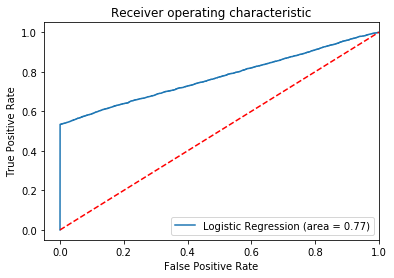

In [0]:
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

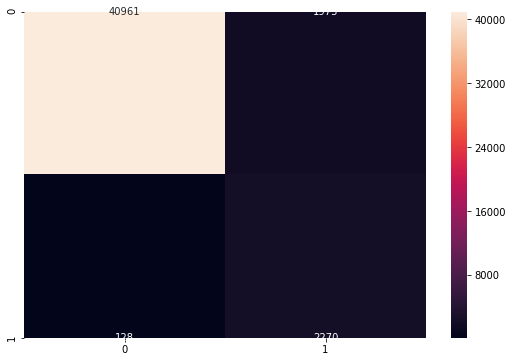

[[40961  1975]
 [  128  2270]]
--*--
Classification par Regression logistique
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     41089
           1       0.95      0.53      0.68      4245

    accuracy                           0.95     45334
   macro avg       0.95      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



In [0]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
y_pred_log = classifier.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_log, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
plt.show()
print(cm)
print('*'.center(5,'-'))
print("Classification par Regression logistique")
print(classification_report(y_true = y_test, y_pred  = classifier.predict(X_test)))

In [0]:
## Analyse des variables :
from sklearn.feature_selection import chi2
khi2 = chi2(X,y)

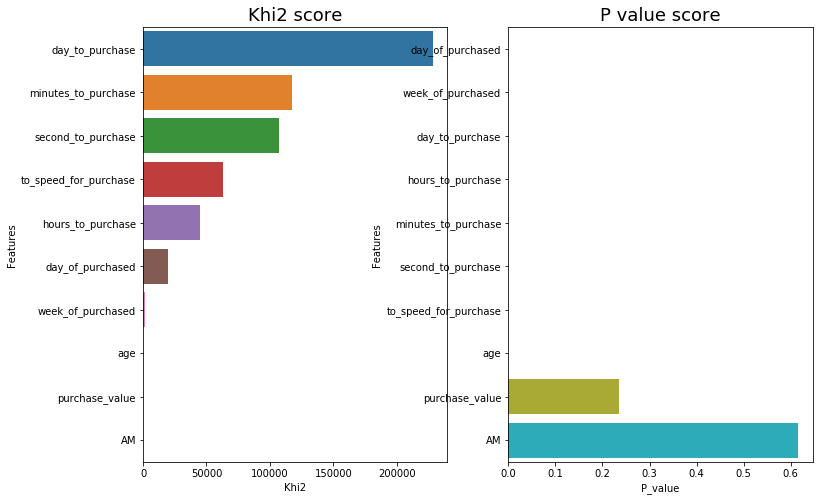

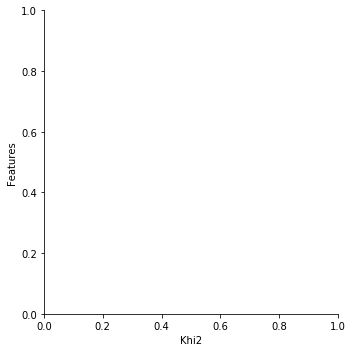

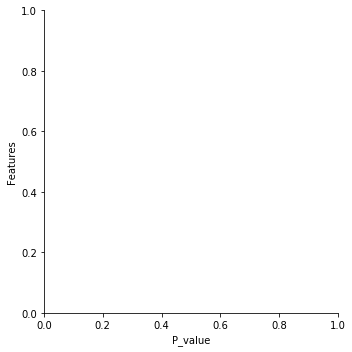

In [0]:
# Feature importance 
feature_ranking = pd.DataFrame({"Features": X_columns,
                                   "Khi2": khi2[0],
                                  "P_value" : khi2[1]})

feature_ranking.sort_values(by = "Khi2", ascending=False)


fig, axarr = plt.subplots(1,2, figsize=(12, 8))
z = feature_ranking.iloc[:10]
sns.catplot(x="Khi2",y="Features", 
            data = z.sort_values("Khi2", ascending=False),
            kind="bar",ax=axarr[0] )
sns.catplot(x="P_value",y="Features", 
            data = z.sort_values("P_value", ascending=True),
            kind="bar",ax=axarr[1])
axarr[0].set_title("Khi2 score", fontsize=18)
axarr[1].set_title("P value score", fontsize=18)
plt.show()

## Decision Tree

In [0]:
y=df['class']
X = df.drop(['class', 'user_id', 'device_id', 'time_to_purchase', 
            'signup_time', 'purchase_time', 'ip_address', 'signup_date', 'signup_hour', 
             'purchase_date','purchase_hour', 'time_to_purchase'
            ], axis = 1)

In [0]:
X = pd.get_dummies(X, drop_first = True)
#enregristre le nom des colonnes 
X_columns = X.columns

In [0]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=.3, random_state = 42, stratify = y)

In [0]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 5)
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
print("Decision tree classifier".center(50, "-"))
print("Tree score on train :",tree.score(X_train, y_train))  ### donne l'accuracy
print("Tree score on test", tree.score(X_test, y_test))

-------------Decision tree classifier-------------
Tree score on train : 0.956881393106317
Tree score on test 0.9561477037102396


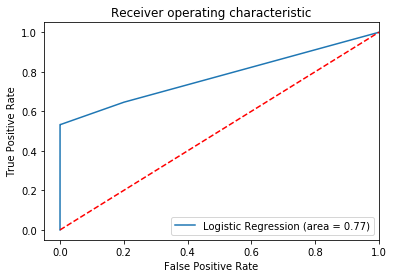

In [0]:
logit_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

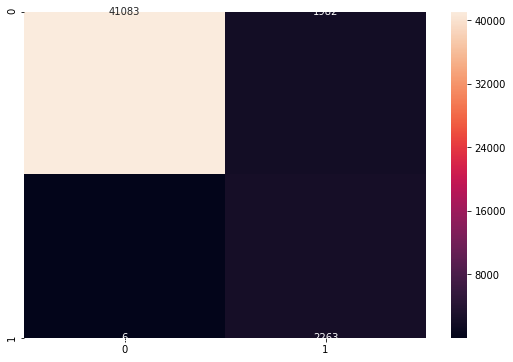

[[41083  1982]
 [    6  2263]]
--*--
Classification par Decision Tree
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.53      0.69      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



In [0]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
y_pred_tree = tree.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_tree, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
plt.show()
print(cm)
print('*'.center(5,'-'))
print("Classification par Decision Tree")
print(classification_report(y_true = y_test, y_pred  = tree.predict(X_test)))

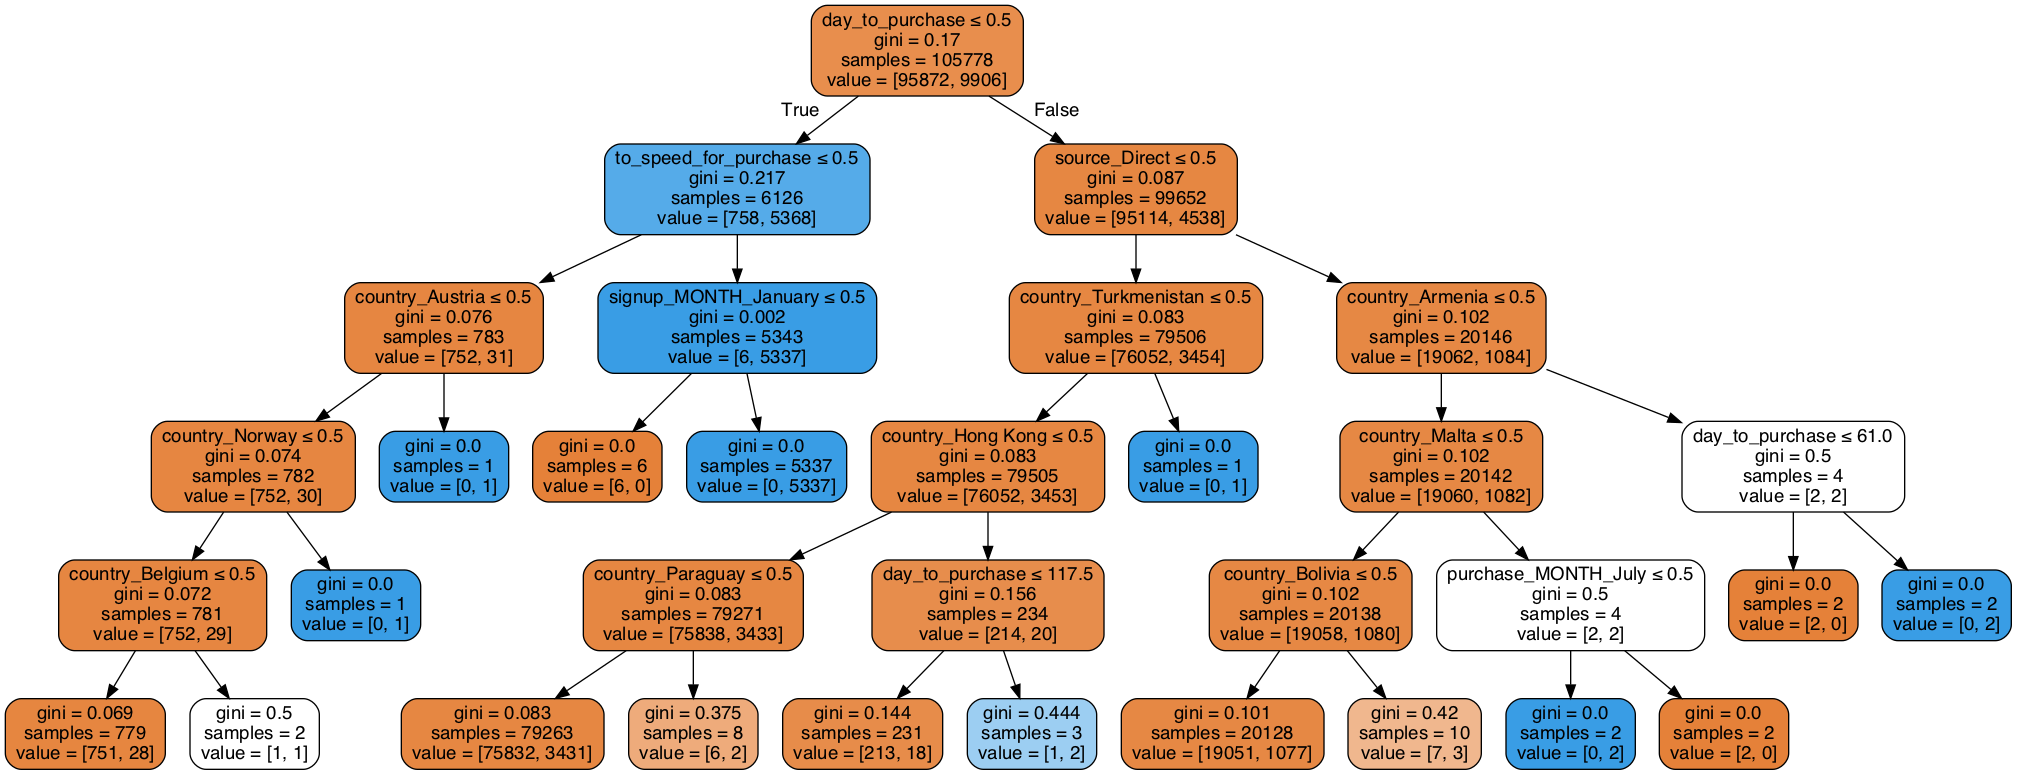

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

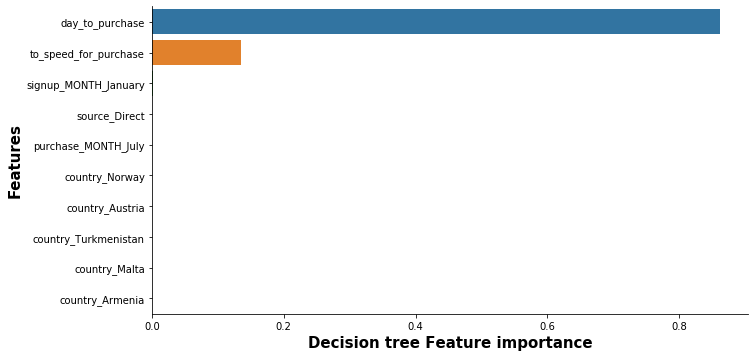

In [0]:
features_ranking_tree= pd.DataFrame(
    {'features' : X.columns,
    'importance' :tree.feature_importances_ }
).sort_values(by = 'importance', ascending = False)
z = features_ranking_tree.iloc[:10]
sns.catplot(x="importance",y="features", 
            data = z.sort_values("importance", ascending=False),
            kind="bar")
plt.gcf().set_size_inches(15, 5)
plt.yticks( size = 10)
plt.xlabel('Decision tree Feature importance', weight = 'bold', size = 15)
plt.ylabel('Features', weight = 'bold', size = 15)
plt.show()

## Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
print("Random Forest classifier".center(50, "-"))
print("Rfc score on train :",rfc.score(X_train, y_train))  ### donne l'accuracy
print("Rfc score on test", rfc.score(X_test, y_test))

-------------Random Forest classifier-------------
Rfc score on train : 0.9999432774300895
Rfc score on test 0.9562800547050778


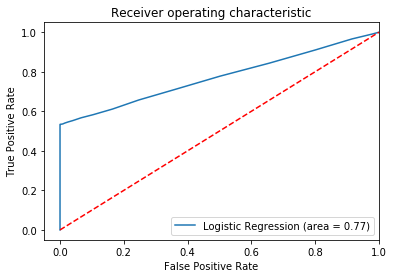

In [0]:
logit_roc_auc = roc_auc_score(y_test, rfc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

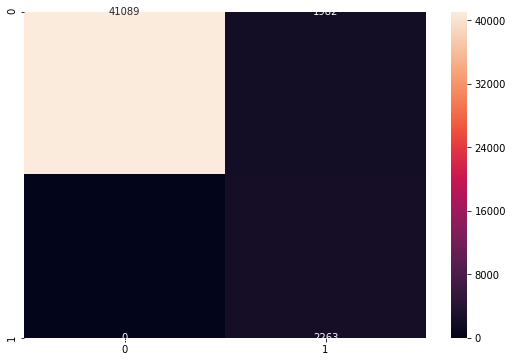

[[41089  1982]
 [    0  2263]]
--*--
Classification par Regression logistique
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.53      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



In [0]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
y_pred_rfc = rfc.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_rfc, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
plt.show()
print(cm)
print('*'.center(5,'-'))
print("Classification par Regression logistique")
print(classification_report(y_true = y_test, y_pred  = rfc.predict(X_test)))
## Random detecte tous les faux positifs --> pas de poursuite judiciaire

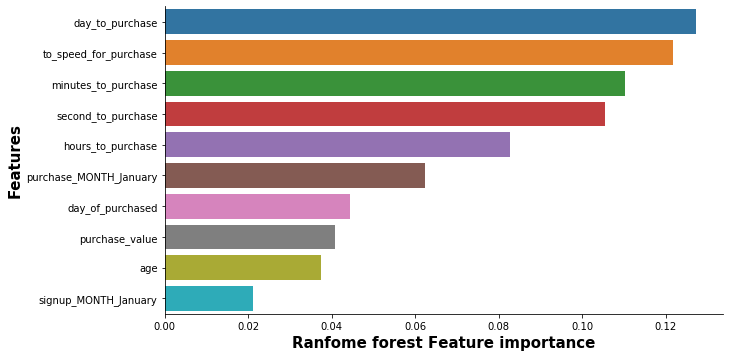

In [0]:
features_ranking_rfc= pd.DataFrame(
    {'features' : X.columns,
    'importance' :rfc.feature_importances_ }
).sort_values(by = 'importance', ascending = False)
z = features_ranking_rfc.iloc[:10]
sns.catplot(x="importance",y="features", 
            data = z.sort_values("importance", ascending=False),
            kind="bar")
plt.gcf().set_size_inches(15, 5)
plt.yticks( size = 10)
plt.xlabel('Ranfome forest Feature importance', weight = 'bold', size = 15)
plt.ylabel('Features', weight = 'bold', size = 15)
plt.show()

In [0]:
# ## recherche des meilleurs paramètres##
# rfc_cv = RandomForestClassifier()
# params = {'max_depth' : [1,10,100],
#          'n_estimators' : [10,50,100,300],
#          'criterion' : ['gini', 'entropy']}

# grid_rfc =  GridSearchCV(estimator=rfc_cv, param_grid= params, cv = 10, n_jobs =-1)
# grid_rfc.fit(X_train, y_train)

In [0]:
#sns.lmplot(x = 'age', y = 'class', data = clean, logistic = True )

In [0]:
#sns.lmplot(x = 'age', y = 'class', data = fraud, logistic = True )

In [0]:
df.isnull().sum()

user_id                      0
signup_time                  0
purchase_time                0
purchase_value               0
device_id                    0
source                       0
browser                      0
sex                          0
age                          0
ip_address                   0
class                        0
country                  21966
signup_date                  0
signup_hour                  0
purchase_date                0
purchase_hour                0
day_of_purchased             0
week_of_purchased            0
signup_MONTH                 0
signup_DAY                   0
purchase_MONTH               0
purchase_DAY                 0
time_to_purchase             0
day_to_purchase              0
hours_to_purchase            0
minutes_to_purchase          0
second_to_purchase           0
to_speed_for_purchase        0
AM                           0
dtype: int64

In [0]:
df.device_id.value_counts()

ZUSVMDEZRBDTX    20
KIPFSCNUGOLDP    20
ITUMJCKWEYNDD    20
CQTUVBYIWWWBC    20
EQYVNEGOFLAWK    20
                 ..
GCRLPJPDAGDAZ     1
WQQGBBSKAUYND     1
NYTONAARSUEZX     1
AYYKNIYAXCWOT     1
OABWCVMBNRUZF     1
Name: device_id, Length: 137956, dtype: int64

In [0]:
df[df['device_id']=='KIPFSCNUGOLDP']['ip_address']

2070      5.760609e+08
3242      5.760609e+08
5614      5.760609e+08
8451      5.760609e+08
38361     5.760609e+08
40300     5.760609e+08
45375     5.760609e+08
63636     5.760609e+08
75008     5.760609e+08
91458     5.760609e+08
100762    5.760609e+08
101060    5.760609e+08
106050    5.760609e+08
111644    5.760609e+08
112251    5.760609e+08
112822    5.760609e+08
121866    5.760609e+08
129717    5.760609e+08
133124    5.760609e+08
148149    5.760609e+08
Name: ip_address, dtype: float64